In [1]:
import pandas as pd
import os
import numpy as np
from copy import deepcopy

In [2]:
st = pd.HDFStore(os.path.expanduser("~/all.h5"), mode='r')

In [3]:
metadata_df = pd.read_csv("metadata/metadata.csv",index_col=0)

In [4]:
feeds = {'use':'aggregate',
        'air1':'hvac',
         'clotheswasher1':'wm',
         'dishwasher1':'dw',
         'microwave1':'mw',
         'refrigerator1':'fridge',
         'oven1':'oven',
        'car1':'ec',
         'waterheater1':'wh',
         'drye1':'dr'
        }

In [5]:
cities = ['Austin','Houston','San Diego','Boulder']

In [6]:
years = {
    2014:{'start':'1-1-2014', 'end':'12-31-2014', 'start_month':1, 'end_month':12, 'months':1},
    2015:{'start':'1-1-2015', 'end':'12-31-2015', 'start_month':1, 'end_month':12, 'months':1},
    2016:{'start':'1-1-2016', 'end':'12-31-2016', 'start_month':1, 'end_month':12, 'months':1}
    }

In [27]:
metadata_df[metadata_df.city=='Boulder'].index

Int64Index([4974, 7213, 6282, 3659, 9229, 2144,  698, 1350, 1766, 2523, 2903,
            3734, 4499, 4703, 4830, 5187, 6083, 6148, 6174, 6956, 7001, 7208,
            8368, 9341, 9818,  879, 2196, 5648, 5954, 8676, 3353,  232,  516,
             547, 1879, 2824, 2931, 3104, 4601, 6264, 6800, 6888, 7818, 8273,
            8622, 8729, 8862, 9085, 9142, 9156, 9958, 5904, 8395, 4920, 5652,
            4147, 5400, 8555],
           dtype='int64', name=u'dataid')

/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


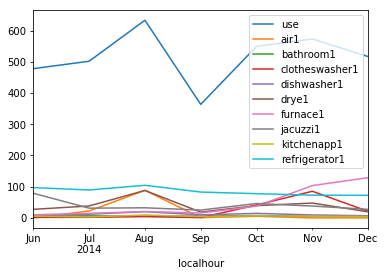

In [34]:
r = st['/1350']['2014']
%matplotlib inline
r.resample("1M", how='mean').plot()

In [7]:
out_overall = {}
for year, year_dict in years.iteritems(): 
    out_overall[year] = {}
    to_ignore = []
    for city in cities[:]:
        print city, year
        city_data = metadata_df[metadata_df['city'] == city]
        city_homes = city_data.index.values.astype('int')
        out = {}
        for home in city_homes[:]:
            
            if home in to_ignore:
                continue
            try:
                data_df = st['/%d' %home][year_dict['start']:year_dict['end']]
                data_df_resampled = data_df.resample("1M").sum()
                df_res_kwh = data_df_resampled.div(1000)
                df_res_kwh.index = df_res_kwh.index.month
                # Find months where we have less than 28 days worth data and ignore those months
                day_res = data_df.resample("1D").sum()['use'].dropna()
                a = pd.value_counts(day_res.index.month)
                lt_28_days = a[a<28].index.values
                
                for m in lt_28_days:
                    df_res_kwh.loc[m] = np.NAN
                    
                temp = {}
                for feed_name, feed_value in feeds.iteritems():
                    temp[feed_value] = []
                    for month in range(year_dict['start_month'], year_dict['end_month']+1):


                        try:
                            temp[feed_value].append(df_res_kwh.loc[month, feed_name])
                        except:
                            temp[feed_value].append(np.NAN)
                out[home] = np.hstack(temp.values())




            except Exception, e:
                pass
        appliances = temp.keys()
        col_headers = []
        for appliance in appliances:
            for month in range(1, 13):
                col_headers.append(appliance+"_"+str(month))
        df = pd.DataFrame(out).T
        df.columns = col_headers

        # Read metadata
        mdf = pd.read_csv("metadata/%s_md.csv" %city.replace(" ",""), index_col=0)
        for column in mdf.columns:
            df[column] = mdf[column]

        city = city.replace(" ","")
        out_overall[year][city] =df

        tdf = df[['aggregate_'+str(month) for month in range(1, 13)]].dropna().copy()
        full_agg = {}
     

        for home in df.index:
            if home in tdf.index:
                full_agg[home] = 1
            

            else:
                full_agg[home] = 0

Austin 2016


/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  app.launch_new_instance()
/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


Houston 2016
San Diego 2016
Boulder 2016
Austin 2014
Houston 2014
San Diego 2014
Boulder 2014
Austin 2015
Houston 2015
San Diego 2015
Boulder 2015


In [8]:
def remove_lt(out_overall):
    for region in ['SanDiego','Austin']:
        for year in [2014, 2015, 2016]:
            df = out_overall[year][region]
            to_remove_agg_lt_appliance = []
            for appliance in ['hvac','wm','dw','mw','fridge','oven']:
                for month in range(1, 13):
                    a=df.query('aggregate_%d<1.35*%s_%d' %(month, appliance, month))
                    if len(a):
                        for x in a.index.values:
                            if x not in to_remove_agg_lt_appliance:
                                to_remove_agg_lt_appliance.append(x)
            print to_remove_agg_lt_appliance, year, region
            out_overall[year][region] = out_overall[year][region].drop(to_remove_agg_lt_appliance)
            
    return out_overall

In [9]:
out_overall = remove_lt(out_overall)

[] 2014 SanDiego
[] 2015 SanDiego
[] 2016 SanDiego
[4800] 2014 Austin
[3531, 8600, 1069] 2015 Austin
[2365, 9971] 2016 Austin


### Removing outliers based on aggregate

1. Remove high energy using z-score test

In [10]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [11]:
out_overall[2014]['Austin'].isnull().sum().sum()

46680L

In [12]:
df['%s_%d' %(appliance, month)].dropna()

232      28.940968
547     118.365952
1350     39.240002
1766     43.629734
2931     41.292316
3104     20.781282
4147     11.389267
4499     49.652897
4830    102.610252
4920     41.793434
4974     40.264103
5400     98.016899
6148      2.899867
6264      5.561083
7001     42.072147
8273     85.967484
8395     13.866684
8555     19.384632
8622     28.466333
8862      1.159867
9085     55.968918
9142     16.650034
9818     51.272167
Name: dr_12, dtype: float64

In [13]:
appliance, month = 'oven', 1
d = out_overall[2014]['Austin']['%s_%d' %(appliance, month)].dropna()
drop_outlier = d.index[is_outlier(d, thresh=5)].values
drop_outlier

array([9745])

In [14]:
d.ix[drop_outlier]

/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


9745    191.942459
Name: oven_1, dtype: float64

In [15]:
from copy import deepcopy
ooc = deepcopy(out_overall)

In [16]:
out_overall =deepcopy(ooc)

In [17]:
APPLIANCES_ORDER = ['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']
year = 2014
to_remove = {}
for region in ['Austin','SanDiego']:
    to_remove[region] = {}
    for year in [2014, 2015, 2016]:
        to_remove[region][year] = {}
        f = out_overall[year][region].copy()
        for appliance in APPLIANCES_ORDER :
            to_remove[region][year][appliance] = []

            for month in range(1, 13):


                # Dropping outlier
                d = f['%s_%d' %(appliance, month)].dropna()
                drop_outlier = d.index[is_outlier(d, thresh=5)].values
                for x in drop_outlier:
                    to_remove[region][year][appliance].append((x, month))

                    f = f.set_value(x, '%s_%d' %(appliance, month),np.NAN)
        out_overall[year][region]=f

/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [18]:
# Setting for missing data
def set_nan(home , months, year=2014, region='Austin'):
    for appliance in APPLIANCES_ORDER:
        for month in months:
            out_overall[year][region] = out_overall[year][region].set_value(home, '%s_%d' %(appliance, month), np.NaN)

In [19]:
set_nan(2378, [5, 6, 7])
set_nan(4297, [6, 7])
set_nan(8086, [5, 6, 7, 8, 9])
set_nan(7017, [7, 8, 9])
set_nan(6941, [8])
set_nan(527, range(1, 13))

In [34]:
out_overall[2014]['Austin'].get_value(2378, 'wm_5')

nan

In [40]:
f.loc[x, '%s_%d' %(appliance, month)]

nan

In [19]:
out_overall[2014]['Austin']['oven_1'].dropna()

26      20.389349
59      14.296000
93       5.864000
545     19.345667
580     42.701817
624      8.255507
871     11.082350
1185    26.386734
1464     5.564333
1617     9.321967
1642     8.153399
1714     2.891200
1718    20.308765
1782    32.791000
2018     8.379316
2129     0.000000
2156    17.751732
2242    19.590416
2335    15.170900
2845    22.527567
2945    12.597549
2965    13.386400
2974     7.293600
3039    63.573235
3192     4.024200
3367    24.649099
3456    16.859684
3652    17.629900
3719    23.825666
3736     4.214883
          ...    
5209    33.329433
5218    12.833433
5357    34.279869
5568     3.725050
5949    14.492417
5972    47.279213
6692     4.909033
6990    24.664684
7536    13.408383
7982    20.048483
8046     6.005633
8047     8.176666
8079    23.060051
8084    13.449284
8142    14.552385
8197    52.818516
8419    22.495684
8597    11.324383
8669    27.312634
9160     9.360017
9340    55.977352
9613    39.292168
9647     5.232000
9771    15.484917
9922    55

In [20]:
import pickle

In [21]:
pickle.dump(out_overall, open('metadata/all_regions_years_cleaned_z_score_5.pkl','w'))

In [22]:
out_overall[year][region].loc[x,'%s_%d' %(appliance, month)]

nan

In [23]:
out_overall[2014]['Austin'].loc[9745,'%s_%d' %('oven', 1)]

nan